In [1]:
import pandas as pd
import random
import seaborn as sns
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
# Définir le nombre de lignes à lire
nrows = 1000000

# Lire le fichier entier
df = pd.read_csv("raw_data/valeursfoncieres-2023.txt", sep="|", dtype=str)

# Sélectionner 100,000 lignes au hasard
chunk = df.sample(n=nrows, random_state=1)

# Liste des colonnes d'intérêt
cols = ['Date mutation', 'Nature mutation', 'Valeur fonciere',
        'Type de voie', 'Code postal', 'Surface Carrez du 1er lot',
        'Surface Carrez du 2eme lot', 'Surface Carrez du 3eme lot',
        'Surface Carrez du 4eme lot', 'Surface Carrez du 5eme lot',
        'Nombre de lots', 'Code type local', 'Surface reelle bati',
        'Nombre pieces principales', 'Surface terrain']

departements = ['75', '13', '69', '31', '06', '44', '34', '67', '33', '59']

# Sélectionner les colonnes
chunk = chunk[cols]
chunk = chunk[chunk['Code postal'].astype(str).str.startswith(tuple(departements))]

In [19]:
# Suppression des lignes qui n'ont pas de 'Valeur fonciere' ou de 'Code postal'
chunk.dropna(subset=['Valeur fonciere', 'Code postal'], inplace=True)

# Filtrer pour ne garder que les 'Vente' classiques
chunk = chunk[chunk['Nature mutation'] == 'Vente']
chunk = chunk[(chunk['Code type local'] == '1') | (chunk['Code type local'] == '2')]
chunk['Date mutation'] = pd.to_datetime(chunk['Date mutation'], format='%d/%m/%Y')

# Colonnes Carrez à traiter
carrez_cols = ['Surface Carrez du 1er lot', 'Surface Carrez du 2eme lot',
               'Surface Carrez du 3eme lot', 'Surface Carrez du 4eme lot',
               'Surface Carrez du 5eme lot']

# Remplacer les virgules par des points dans les colonnes numériques
chunk['Valeur fonciere'] = chunk['Valeur fonciere'].str.replace(',', '.').astype(float)
chunk[carrez_cols] = chunk[carrez_cols].apply(lambda col: col.str.replace(',', '.').astype(float))

# Remplacer les NaN dans les colonnes Carrez par 0
chunk[carrez_cols] = chunk[carrez_cols].fillna(0)
chunk['somme surface carrez'] = chunk[carrez_cols].sum(axis=1)

# Supprimer les colonnes contenant les surfaces carrez
chunk.drop(columns=carrez_cols, inplace=True)
chunk[['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']] = chunk[['Surface reelle bati', 'Nombre pieces principales', 'Surface terrain']].fillna(0).astype(float)
chunk[['Nombre de lots', 'Code type local']] = chunk[['Nombre de lots', 'Code type local']].fillna(0).astype(int)

# Filtrer pour enlever les lignes où 'Nombre de lots', 'Surface reelle bati', ou 'somme surface carrez' sont égales à 0
chunk = chunk[(chunk['Nombre de lots'] != 0) |
              (chunk['Surface reelle bati'] != 0) |
              (chunk['somme surface carrez'] != 0)]

# Ajouter un zéro à la fin des codes postaux qui ont moins de 5 caractères
chunk['Code postal'] = chunk['Code postal'].astype(str).apply(lambda x: x + '0' * (5 - len(x)) if len(x) < 5 else x)

# Clean Code Type Local : d'int à object
chunk['Code type local'] = chunk['Code type local'].astype('object')

# Clean Nombre pieces principales : de float à int
chunk['Nombre pieces principales'] = chunk['Nombre pieces principales'].astype(int)

# Ajout d'une colonne mois, d'une colonne annéee, suppression de Date Mutation et Nature Mutation
chunk['Month mutation'] = chunk['Date mutation'].dt.month
chunk['Year mutation'] = chunk['Date mutation'].dt.year
chunk = chunk.drop(columns=['Date mutation', 'Nature mutation'])

In [22]:
# Gestion des outliers

# Calcul du Z-score
df=chunk.copy()
df['z_score'] = stats.zscore(df['Valeur fonciere'])
outliers = df[df['z_score'].abs() > 3]  # Seuil de 3

In [23]:
#Remove outliers
chunk = df[df['z_score'].abs() <= 3]

In [25]:
#Drop z_score
chunk = chunk.drop(['z_score'], axis=1)

VALEUR FONCIERE (Y) : Grande disparité de valeurs (entre 1 et 12M après exclusion des valeurs extremes).
On choisit de se concentrer sur les valeurs entre 1 et 2M pour la représentation graphique pour des raisons esthétiques et de lisibilité.

In [32]:
#Inspection préliminaire
valeur_fonciere_counts = chunk['Valeur fonciere'].value_counts().reset_index()
valeur_fonciere_counts.columns = ['Valeur fonciere', 'Fréquence']
valeur_fonciere_counts = valeur_fonciere_counts.sort_values('Valeur fonciere')
valeur_fonciere_counts

,Valeur fonciere,Fréquence
57,1.0,171
6374,2.0,1
6620,6.0,1
9961,47.0,1
3550,50.0,2
...,...,...
600,11483882.0,13
541,11731253.0,15
14721,11763600.0,1
4767,11775189.0,1


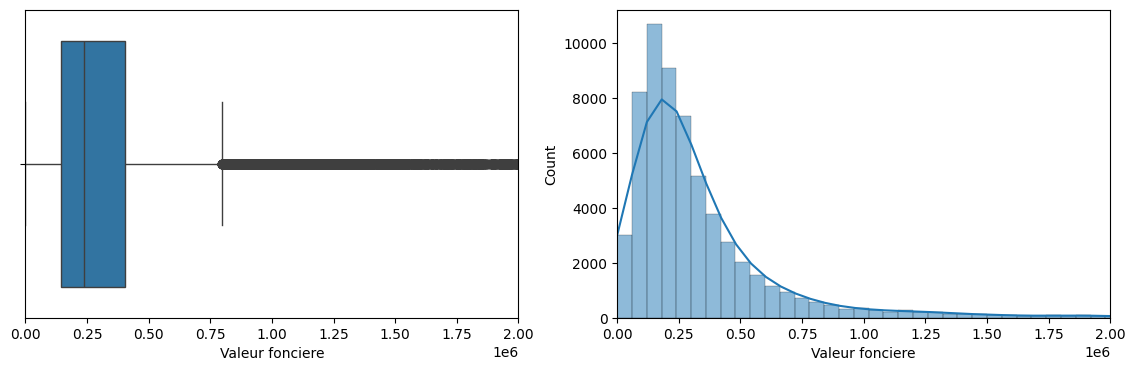

In [31]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.boxplot(data=chunk, x='Valeur fonciere')
plt.xlim(0, 2000000);
plt.subplot(1,2,2)
sns.histplot(chunk['Valeur fonciere'], bins=200, kde=True)
plt.xlim(0, 2000000);

MONTH MUTATION : Le jeu de données est équilibré en terme de répartition entre les mois. Pas d'alerte.<br>
On a supprimé date mutation pour ne garder que le mois et l'année (et ainsi pouvoir combiner les fichiers entre 2019 et 2023)

In [36]:
#Inspection préliminaire
month_mutation_counts = chunk['Month mutation'].value_counts().reset_index()
month_mutation_counts.columns = ['Month mutation', 'Fréquence']

month_mutation_counts = month_mutation_counts.sort_values('Month mutation')
month_mutation_counts

,Month mutation,Fréquence
4,1,5148
8,2,4755
2,3,5852
9,4,4751
7,5,4967
1,6,6315
0,7,6337
10,8,4271
3,9,5458
6,10,5018


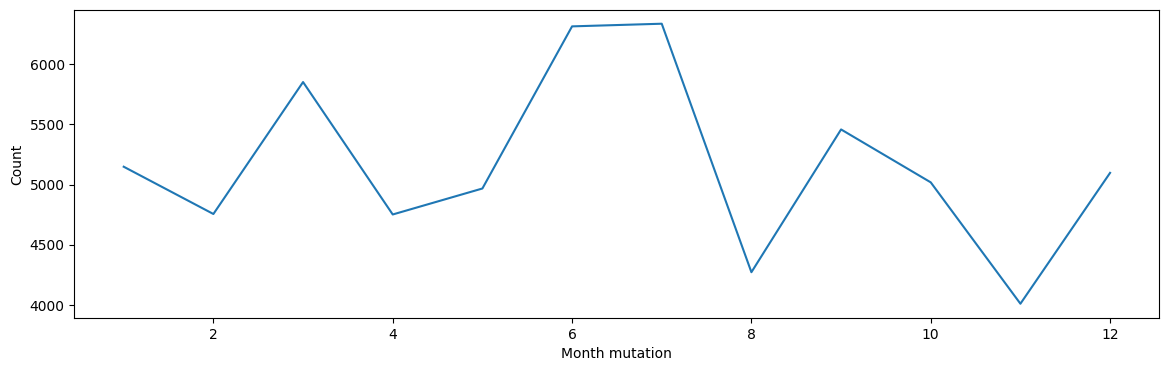

In [59]:
plt.figure(figsize=(14,4))
plt.plot(month_mutation_counts['Month mutation'], month_mutation_counts['Fréquence'])
plt.xlabel('Month mutation')
plt.ylabel('Count');


NATURE MUTATION : on ne garde que les ventes pour la pertinence de l'analyse et la création d'un modèle pertinent.

TYPE DE VOIE : 84 valeurs différentes de base, dont beaucoup ayant une fréquence entre 1 et 10. Réduction à 11 valeurs (10 plus fréquentes + les autres)

In [54]:
type_voie_to_keep = ['RUE', 'AV', 'CHE', 'BD', 'RTE', 'ALL', 'IMP', 'PL', 'RES', 'CRS']
chunk['Type de voie'] = chunk['Type de voie'].where(chunk['Type de voie'].isin(type_voie_to_keep), 'AUTRE')

In [57]:
#Inspection préliminaire
type_voie_counts = chunk['Type de voie'].value_counts().reset_index()
type_voie_counts.columns = ['Type de voie', 'Fréquence']
type_voie_counts = type_voie_counts.sort_values('Fréquence', ascending=False)
type_voie_counts.head(11)

,Type de voie,Fréquence
0,RUE,34384
1,AV,6803
2,AUTRE,6686
3,CHE,3181
4,BD,2909
5,RTE,2398
6,ALL,1846
7,IMP,1522
8,PL,994
9,RES,749


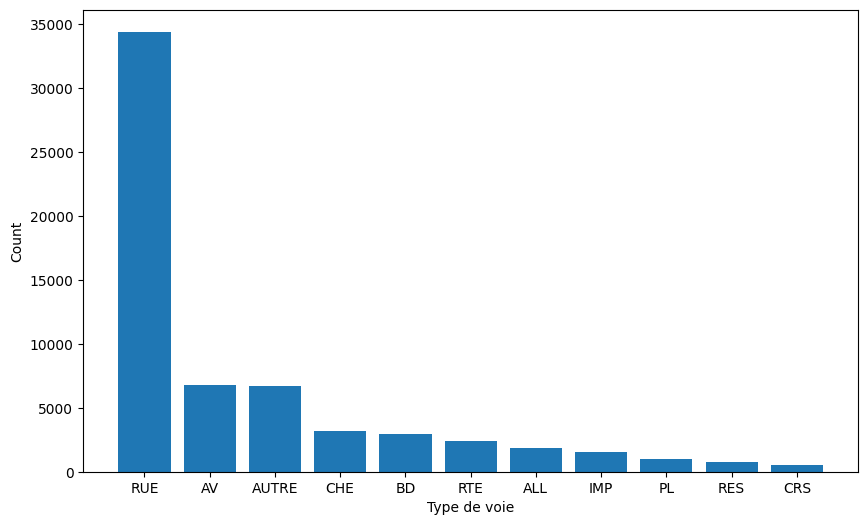

In [62]:
#Visualisation graphique
plt.figure(figsize=(10, 6))
plt.bar(type_voie_counts['Type de voie'], type_voie_counts['Fréquence'])
plt.xlabel('Type de voie')
plt.ylabel('Count')
plt.show()

NOMBRE DE LOTS : de 0 à 11 lots, ok pour analyse pas d'alerte.

In [63]:
#Inspection préliminaire
nombre_lots_counts = chunk['Nombre de lots'].value_counts().reset_index()
nombre_lots_counts.columns = ['Nombre de lots', 'Fréquence']
nombre_lots_counts = nombre_lots_counts.sort_values('Fréquence', ascending=False)
nombre_lots_counts

,Nombre de lots,Fréquence
0,0,29916
1,1,19316
2,2,11107
3,3,1191
4,4,278
5,5,85
6,6,42
7,7,20
8,8,8
9,9,6


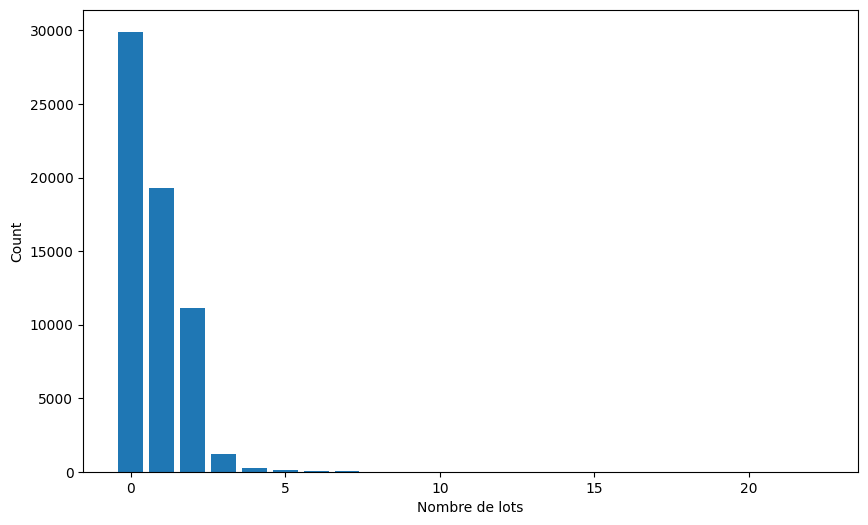

In [66]:
#Visualisation graphique
plt.figure(figsize=(10, 6))
plt.bar(nombre_lots_counts['Nombre de lots'], nombre_lots_counts['Fréquence'])
plt.xlabel('Nombre de lots')
plt.ylabel('Count')
plt.show()

Creation de somme surface carrez, somme des surfaces de chaque lot relatif à une vente. Variable assez complexe car encore pas mal de valeurs extremes meme après clean. Les valeurs sont tres différentes et étalées ce qui peut rendre l'analyse compliquée.

In [93]:
#Inspection préliminaire
surface_carrez_counts = chunk['somme surface carrez'].value_counts().reset_index()
surface_carrez_counts.columns = ['somme surface carrez', 'Fréquence']
surface_carrez_counts = surface_carrez_counts.sort_values('Fréquence', ascending=False)
surface_carrez_counts

,somme surface carrez,Fréquence
0,0.00,41424
1,40.00,19
2,47.00,16
3,44.00,15
4,62.00,15
...,...,...
6362,106.10,1
6363,91.71,1
6364,21.71,1
6365,32.96,1


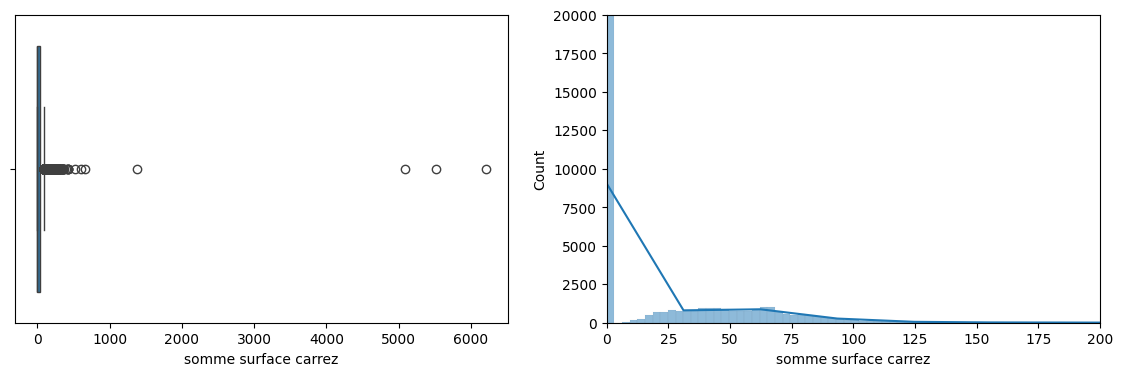

In [110]:
#Visualisation graphique
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.boxplot(data=chunk, x='somme surface carrez')

plt.subplot(1,2,2)
sns.histplot(chunk['somme surface carrez'], bins=2000, kde=True)
plt.xlim(0, 200);
plt.ylim(0, 20000);


CODE POSTAL : transformation des codes postaux en départements (+ on se focalise sur les 10 plus grandes villes, pas d'alerte, assez bien réparti)

In [116]:
chunk['departement'] = chunk['Code postal'].str[:2]

departement_counts = chunk['departement'].fillna('NaN').value_counts().reset_index()
departement_counts.columns = ['departement', 'Fréquence']
departement_counts = departement_counts.sort_values('Fréquence', ascending=False)
departement_counts

,departement,Fréquence
8,67,283
7,44,6385
6,31,6410
5,69,6787
4,34,7092
3,33,7651
2,13,8704
1,75,9184
0,59,9482


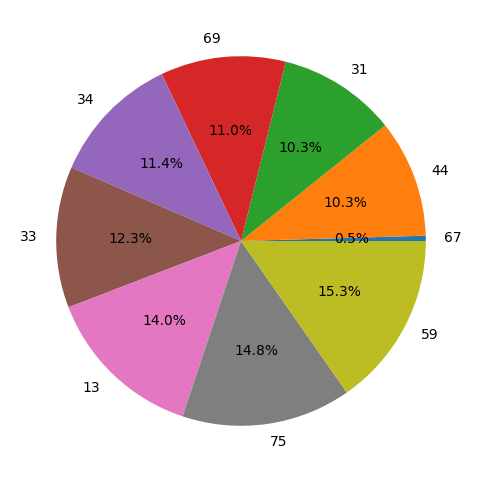

In [118]:
#Visualisation graphique
plt.figure(figsize=(6, 6))
plt.pie(departement_counts['Fréquence'], labels=departement_counts['departement'], autopct='%1.1f%%')
plt.show()

CODE TYPE LOCAL >> Me souviens plus, présence d'un local ou non ?

In [119]:
#Inspection préliminaire
codetypelocal_counts = chunk['Code type local'].fillna('NaN').value_counts().reset_index()
codetypelocal_counts.columns = ['Code type local', 'Fréquence']
codetypelocal_counts = codetypelocal_counts.sort_values('Code type local', ascending=True)
codetypelocal_counts

,Code type local,Fréquence
1,1,26040
0,2,35938


In [ ]:
#Visualisation graphique
#Pas utile

SURFACE REELLE BATI : beaucoup de donnees eparses encore. Encore des valeurs extremes malgré leur suppression prealable. Pas cohérent car seulement deux 0 alors que somme surface carrez a 41k 0. A creuser ? 

In [130]:
#Inspection préliminaire
surfacereelle_counts = chunk['Surface reelle bati'].value_counts().reset_index()
surfacereelle_counts.columns = ['Surface reelle bati', 'Fréquence']
surfacereelle_counts = surfacereelle_counts.sort_values('Surface reelle bati', ascending=False)
surfacereelle_counts

,Surface reelle bati,Fréquence
364,930.0,1
305,751.0,2
224,700.0,9
374,640.0,1
339,600.0,1
...,...,...
296,4.0,2
288,3.0,3
256,2.0,5
211,1.0,12


<Axes: xlabel='Surface reelle bati', ylabel='Count'>

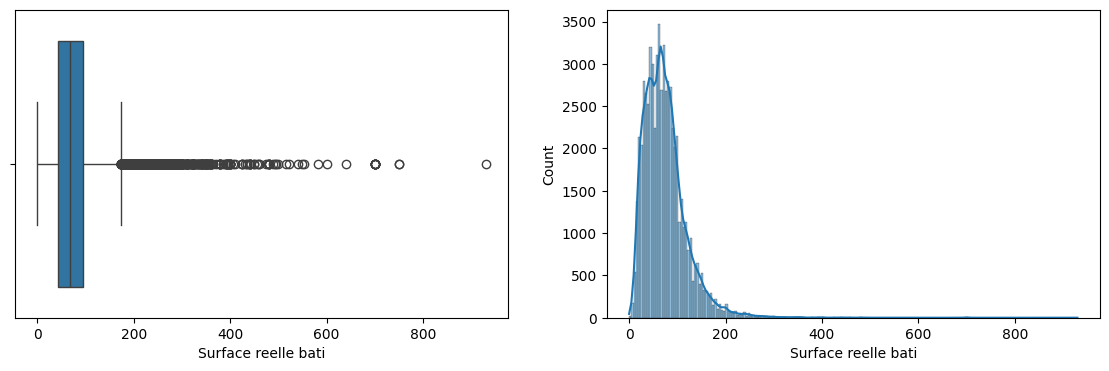

In [137]:
#Représentation graphique 
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.boxplot(data=chunk, x='Surface reelle bati')
#plt.xlim(0, 2000000);
plt.subplot(1,2,2)
sns.histplot(chunk['Surface reelle bati'], bins=200, kde=True)


NOMBRE PIECES PRINCIPALES : de 0 à 34 pièces principales, pas d'incohérence, ok pour analyse.

In [140]:
#Inspection préliminaire
nb_pieces_counts = chunk['Nombre pieces principales'].value_counts().reset_index()
nb_pieces_counts.columns = ['Nombre pieces principales', 'Fréquence']
nb_pieces_counts = nb_pieces_counts.sort_values('Nombre pieces principales', ascending=True)
nb_pieces_counts

,Nombre pieces principales,Fréquence
9,0,121
3,1,8396
2,2,13056
0,3,14918
1,4,13917
4,5,7479
5,6,2546
6,7,936
7,8,345
8,9,124


<Axes: xlabel='Nombre pieces principales', ylabel='Count'>

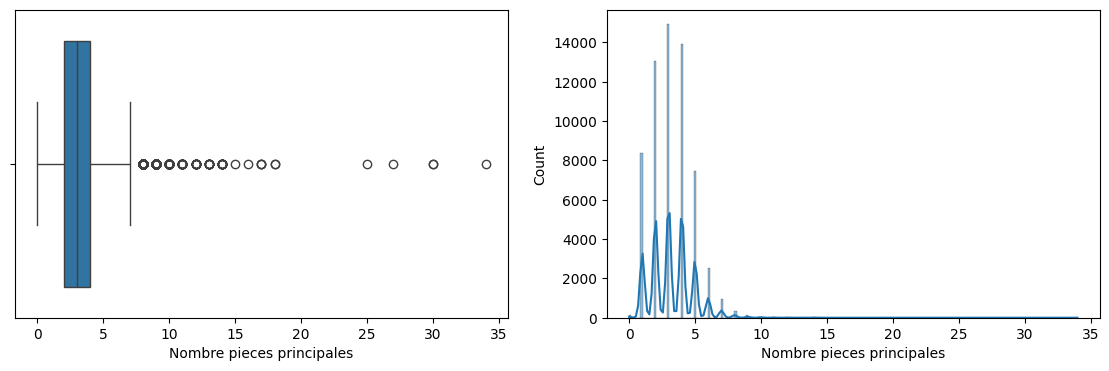

In [139]:
#Représentation graphique 
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.boxplot(data=chunk, x='Nombre pieces principales')
#plt.xlim(0, 2000000);
plt.subplot(1,2,2)
sns.histplot(chunk['Nombre pieces principales'], bins=200, kde=True)

SRUFACE TERRAIN : Entre 0 et 276k, toujours beaucoup de données extremes.

In [141]:
#Inspection préliminaire
surface_terrain_counts = chunk['Surface terrain'].value_counts().reset_index()
surface_terrain_counts.columns = ['Surface terrain', 'Fréquence']
surface_terrain_counts = surface_terrain_counts.sort_values('Surface terrain', ascending=True)
surface_terrain_counts

,Surface terrain,Fréquence
0,0.0,32446
1199,1.0,4
1184,2.0,4
2209,3.0,1
1451,4.0,2
...,...,...
2725,114200.0,1
1646,115330.0,2
793,137520.0,11
2148,264051.0,1


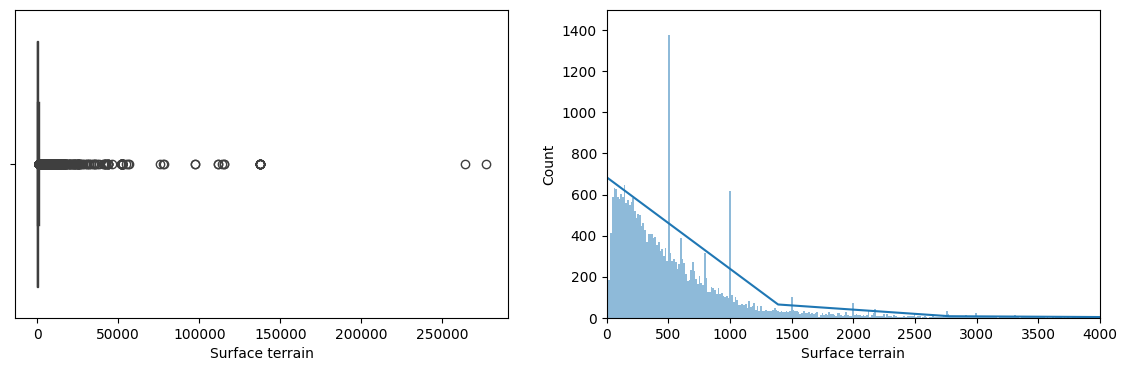

In [149]:
#Représentation graphique 
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
sns.boxplot(data=chunk, x='Surface terrain')
plt.subplot(1,2,2)
sns.histplot(chunk['Surface terrain'], bins=20000, kde=True)
plt.xlim(0, 4000)
plt.ylim(0, 1500);